# Data Loading

In [2]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from category_encoders import HashingEncoder
from sklearn.metrics import accuracy_score, confusion_matrix,roc_auc_score, roc_curve
from sklearn.model_selection import train_test_split, cross_val_score
from catboost import CatBoostClassifier
from sklearn.metrics import precision_recall_curve
import missingno as msno
import matplotlib.pyplot as plt
import category_encoders as ce
import datetime

In [3]:
dfs = pd.read_csv('model/data/ga_hits.csv', low_memory=False)
dfs.shape
duplicates_count = dfs['session_id'].duplicated().sum()
unique_session_ids = dfs['session_id'].unique()
print("Количество дубликатов в session :",duplicates_count)
print("Количество пропущенных значений в session :", dfs['session_id'].isna().sum())  
print("Количество дубликатов  :",  dfs.duplicated().sum())
dfs.info()

Количество дубликатов в session : 13991860
Количество пропущенных значений в session : 0
Количество дубликатов  : 0
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15726470 entries, 0 to 15726469
Data columns (total 11 columns):
 #   Column          Dtype  
---  ------          -----  
 0   session_id      object 
 1   hit_date        object 
 2   hit_time        float64
 3   hit_number      int64  
 4   hit_type        object 
 5   hit_referer     object 
 6   hit_page_path   object 
 7   event_category  object 
 8   event_action    object 
 9   event_label     object 
 10  event_value     float64
dtypes: float64(2), int64(1), object(8)
memory usage: 1.3+ GB


In [4]:
df = pd.read_csv('model/data/ga_sessions.csv',low_memory=False)
print(df['session_id'].nunique())
print(dfs['session_id'].nunique())
df.info()

1860042
1734610
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1860042 entries, 0 to 1860041
Data columns (total 18 columns):
 #   Column                    Dtype 
---  ------                    ----- 
 0   session_id                object
 1   client_id                 object
 2   visit_date                object
 3   visit_time                object
 4   visit_number              int64 
 5   utm_source                object
 6   utm_medium                object
 7   utm_campaign              object
 8   utm_adcontent             object
 9   utm_keyword               object
 10  device_category           object
 11  device_os                 object
 12  device_brand              object
 13  device_model              object
 14  device_screen_resolution  object
 15  device_browser            object
 16  geo_country               object
 17  geo_city                  object
dtypes: int64(1), object(17)
memory usage: 255.4+ MB


In [5]:
desired_event_actions =  ['sub_car_claim_click', 'sub_car_claim_submit_click',
'sub_open_dialog_click', 'sub_custom_question_submit_click',
'sub_call_number_click', 'sub_callback_submit_click', 'sub_submit_success',
'sub_car_request_submit_click']
dfs['flag'] = 0
dfs.loc[dfs['event_action'].isin(desired_event_actions), 'flag'] = 1
grouped_dfs = dfs.groupby('session_id')['flag'].max().reset_index()
print(grouped_dfs.shape)

(1734610, 2)


In [6]:
merged_df = df.merge(grouped_dfs, on='session_id', how='inner')
merged_df.info()
#merged_df.flag.value_counts()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1732266 entries, 0 to 1732265
Data columns (total 19 columns):
 #   Column                    Dtype 
---  ------                    ----- 
 0   session_id                object
 1   client_id                 object
 2   visit_date                object
 3   visit_time                object
 4   visit_number              int64 
 5   utm_source                object
 6   utm_medium                object
 7   utm_campaign              object
 8   utm_adcontent             object
 9   utm_keyword               object
 10  device_category           object
 11  device_os                 object
 12  device_brand              object
 13  device_model              object
 14  device_screen_resolution  object
 15  device_browser            object
 16  geo_country               object
 17  geo_city                  object
 18  flag                      int64 
dtypes: int64(2), object(17)
memory usage: 251.1+ MB


In [7]:
desired_event_actions =  ['sub_car_claim_click', 'sub_car_claim_submit_click',
'sub_open_dialog_click', 'sub_custom_question_submit_click',
'sub_call_number_click', 'sub_callback_submit_click', 'sub_submit_success',
'sub_car_request_submit_click']
dfs['flag'] = 0
dfs.loc[dfs['event_action'].isin(desired_event_actions), 'flag'] = 1
grouped_dfs = dfs.groupby('session_id')['flag'].max().reset_index()
print(grouped_dfs.shape)

(1734610, 2)


In [8]:
conversion_rate = merged_df['flag'].mean()
print("Конверсия в целевое действие (flag=1):", conversion_rate)

Конверсия в целевое действие (flag=1): 0.02904519282835315


In [9]:
merged_df.head(10)

,session_id,client_id,visit_date,visit_time,visit_number,utm_source,utm_medium,utm_campaign,utm_adcontent,utm_keyword,device_category,device_os,device_brand,device_model,device_screen_resolution,device_browser,geo_country,geo_city,flag
0,9055434745589932991.1637753792.1637753792,2108382700.1637753791,2021-11-24,14:36:32,1,ZpYIoDJMcFzVoPFsHGJL,banner,LEoPHuyFvzoNfnzGgfcd,vCIpmpaGBnIQhyYNkXqp,puhZPIYqKXeFPaUviSjo,mobile,Android,Huawei,NaN,360x720,Chrome,Russia,Zlatoust,0
1,905544597018549464.1636867290.1636867290,210838531.1636867288,2021-11-14,08:21:30,1,MvfHsxITijuriZxsqZqt,cpm,FTjNLDyTrXaWYgZymFkV,xhoenQgDQsgfEPYNPwKO,IGUCNvHlhfHpROGclCit,mobile,Android,Samsung,NaN,385x854,Samsung Internet,Russia,Moscow,0
2,9055446045651783499.1640648526.1640648526,2108385331.1640648523,2021-12-28,02:42:06,1,ZpYIoDJMcFzVoPFsHGJL,banner,LEoPHuyFvzoNfnzGgfcd,vCIpmpaGBnIQhyYNkXqp,puhZPIYqKXeFPaUviSjo,mobile,Android,Huawei,NaN,360x720,Chrome,Russia,Krasnoyarsk,0
3,9055447046360770272.1622255328.1622255328,2108385564.1622255328,2021-05-29,05:00:00,1,kjsLglQLzykiRbcDiGcD,cpc,NaN,NOBKLgtuvqYWkXQHeYWM,NaN,mobile,NaN,Xiaomi,NaN,393x786,Chrome,Russia,Moscow,0
4,9055447046360770272.1622255345.1622255345,2108385564.1622255328,2021-05-29,05:00:00,2,kjsLglQLzykiRbcDiGcD,cpc,NaN,NaN,NaN,mobile,NaN,Xiaomi,NaN,393x786,Chrome,Russia,Moscow,0
5,9055447192389856083.1622453074.1622453074,2108385598.1622453075,2021-05-31,12:00:00,1,kjsLglQLzykiRbcDiGcD,organic,LTuZkdKfxRGVceoWkVyg,JNHcPlZPxEMWDnRiyoBf,NaN,mobile,NaN,Apple,NaN,375x812,Safari,Russia,Saint Petersburg,0
6,9055455318486370642.1640843788.1640843788,2108387490.1640843602,2021-12-30,08:56:28,1,TxKUcPpthBDPieTGmVhx,cpc,FTjNLDyTrXaWYgZymFkV,LcGIUNPUAmXtQJaDfFBR,PwscUHjoUJDrtfWESIHj,tablet,Android,Lenovo,NaN,602x1029,YaBrowser,Russia,Saint Petersburg,0
7,9055461992850812764.1626107740.1626107740,2108389044.1626107740,2021-07-12,19:00:00,1,ZpYIoDJMcFzVoPFsHGJL,banner,LEoPHuyFvzoNfnzGgfcd,JNHcPlZPxEMWDnRiyoBf,NaN,mobile,NaN,Samsung,NaN,360x640,Chrome,Russia,Saint Petersburg,0
8,9055462349345527315.1638536723.1638536723,2108389127.1638536723,2021-12-03,16:05:23,1,ZpYIoDJMcFzVoPFsHGJL,banner,LEoPHuyFvzoNfnzGgfcd,vCIpmpaGBnIQhyYNkXqp,puhZPIYqKXeFPaUviSjo,mobile,iOS,Apple,NaN,390x844,Safari,Russia,Moscow,0
9,9055466554104774132.1624800757.1624800757,2108390106.1624800756,2021-06-27,16:00:00,1,ZpYIoDJMcFzVoPFsHGJL,banner,LEoPHuyFvzoNfnzGgfcd,JNHcPlZPxEMWDnRiyoBf,NaN,mobile,NaN,Samsung,NaN,412x915,Chrome,Russia,Moscow,0


# Data Preparation

## Feauture Engineering

In [10]:
missing_percentage = merged_df.isnull().mean() * 100
print(missing_percentage)

session_id                   0.000000
client_id                    0.000000
visit_date                   0.000000
visit_time                   0.000000
visit_number                 0.000000
utm_source                   0.004387
utm_medium                   0.000000
utm_campaign                11.273500
utm_adcontent               17.557177
utm_keyword                 58.925823
device_category              0.000000
device_os                   58.533966
device_brand                20.042880
device_model                99.130503
device_screen_resolution     0.000000
device_browser               0.000000
geo_country                  0.000000
geo_city                     0.000000
flag                         0.000000
dtype: float64


In [11]:
new_df = merged_df.copy()
new_df.head()

,session_id,client_id,visit_date,visit_time,visit_number,utm_source,utm_medium,utm_campaign,utm_adcontent,utm_keyword,device_category,device_os,device_brand,device_model,device_screen_resolution,device_browser,geo_country,geo_city,flag
0,9055434745589932991.1637753792.1637753792,2108382700.1637753791,2021-11-24,14:36:32,1,ZpYIoDJMcFzVoPFsHGJL,banner,LEoPHuyFvzoNfnzGgfcd,vCIpmpaGBnIQhyYNkXqp,puhZPIYqKXeFPaUviSjo,mobile,Android,Huawei,NaN,360x720,Chrome,Russia,Zlatoust,0
1,905544597018549464.1636867290.1636867290,210838531.1636867288,2021-11-14,08:21:30,1,MvfHsxITijuriZxsqZqt,cpm,FTjNLDyTrXaWYgZymFkV,xhoenQgDQsgfEPYNPwKO,IGUCNvHlhfHpROGclCit,mobile,Android,Samsung,NaN,385x854,Samsung Internet,Russia,Moscow,0
2,9055446045651783499.1640648526.1640648526,2108385331.1640648523,2021-12-28,02:42:06,1,ZpYIoDJMcFzVoPFsHGJL,banner,LEoPHuyFvzoNfnzGgfcd,vCIpmpaGBnIQhyYNkXqp,puhZPIYqKXeFPaUviSjo,mobile,Android,Huawei,NaN,360x720,Chrome,Russia,Krasnoyarsk,0
3,9055447046360770272.1622255328.1622255328,2108385564.1622255328,2021-05-29,05:00:00,1,kjsLglQLzykiRbcDiGcD,cpc,NaN,NOBKLgtuvqYWkXQHeYWM,NaN,mobile,NaN,Xiaomi,NaN,393x786,Chrome,Russia,Moscow,0
4,9055447046360770272.1622255345.1622255345,2108385564.1622255328,2021-05-29,05:00:00,2,kjsLglQLzykiRbcDiGcD,cpc,NaN,NaN,NaN,mobile,NaN,Xiaomi,NaN,393x786,Chrome,Russia,Moscow,0


In [12]:
new_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1732266 entries, 0 to 1732265
Data columns (total 19 columns):
 #   Column                    Dtype 
---  ------                    ----- 
 0   session_id                object
 1   client_id                 object
 2   visit_date                object
 3   visit_time                object
 4   visit_number              int64 
 5   utm_source                object
 6   utm_medium                object
 7   utm_campaign              object
 8   utm_adcontent             object
 9   utm_keyword               object
 10  device_category           object
 11  device_os                 object
 12  device_brand              object
 13  device_model              object
 14  device_screen_resolution  object
 15  device_browser            object
 16  geo_country               object
 17  geo_city                  object
 18  flag                      int64 
dtypes: int64(2), object(17)
memory usage: 251.1+ MB


In [13]:
columns_to_replace = ['utm_campaign', 'utm_adcontent', 'utm_keyword', 'utm_source', 'device_brand','geo_city', 'geo_country','device_os','device_model']
columns_to_replaceset = ['geo_city', 'geo_country', 'device_brand','utm_medium']
new_df[columns_to_replace] =new_df[columns_to_replace].replace(['', pd.NA], 'other')
new_df[columns_to_replaceset] = new_df[columns_to_replaceset].replace(r'\(other\)', 'other', regex=True)
new_df[columns_to_replaceset] = new_df[columns_to_replaceset].replace(r'\(not set\)', 'other', regex=True)
new_df['utm_medium'] = new_df['utm_medium'].replace({'referral': 'organic', 'organic': 'organic', '\(none\)': 'organic'}, regex=True)
new_df['visit_datetime'] = pd.to_datetime(new_df['visit_date'] + ' ' + new_df['visit_time'], format='%Y-%m-%d %H:%M:%S')
new_df['day'] = new_df['visit_datetime'].dt.day
new_df['weekday'] = new_df['visit_datetime'].dt.weekday
new_df['month'] = new_df['visit_datetime'].dt.month
new_df['hour'] = new_df['visit_datetime'].dt.hour
new_df['device_browser_first'] = new_df['device_browser'].str.split().str[0]
new_df[['height', 'width']] = new_df['device_screen_resolution'].str.extract(r'(\d+)x(\d+)')
new_df['height'] = new_df['height'].astype(int)
new_df['width'] = new_df['width'].astype(int)
new_df['resolution_sum'] = new_df['height'] + new_df['width']
bins = [0, 1000, 2000, 3000, float('inf')]
labels = ['low', 'medium', 'big', 'extra']
new_df['resolution_category'] = pd.cut(new_df['resolution_sum'], bins=bins, labels=labels)
new_df['traffic_type'] = new_df['utm_medium'].where(new_df['utm_medium'].isin(['organic']), 'inorganic')
#new_df['resolution_category'] =new_df['resolution_category'].replace(['', pd.NA], 'other')
new_df['resolution_category'] = new_df['resolution_category'].astype(str).fillna('other')

In [14]:
new_df.head()

,session_id,client_id,visit_date,visit_time,visit_number,utm_source,utm_medium,utm_campaign,utm_adcontent,utm_keyword,...,day,weekday,month,hour,device_browser_first,height,width,resolution_sum,resolution_category,traffic_type
0,9055434745589932991.1637753792.1637753792,2108382700.1637753791,2021-11-24,14:36:32,1,ZpYIoDJMcFzVoPFsHGJL,banner,LEoPHuyFvzoNfnzGgfcd,vCIpmpaGBnIQhyYNkXqp,puhZPIYqKXeFPaUviSjo,...,24,2,11,14,Chrome,360,720,1080,medium,inorganic
1,905544597018549464.1636867290.1636867290,210838531.1636867288,2021-11-14,08:21:30,1,MvfHsxITijuriZxsqZqt,cpm,FTjNLDyTrXaWYgZymFkV,xhoenQgDQsgfEPYNPwKO,IGUCNvHlhfHpROGclCit,...,14,6,11,8,Samsung,385,854,1239,medium,inorganic
2,9055446045651783499.1640648526.1640648526,2108385331.1640648523,2021-12-28,02:42:06,1,ZpYIoDJMcFzVoPFsHGJL,banner,LEoPHuyFvzoNfnzGgfcd,vCIpmpaGBnIQhyYNkXqp,puhZPIYqKXeFPaUviSjo,...,28,1,12,2,Chrome,360,720,1080,medium,inorganic
3,9055447046360770272.1622255328.1622255328,2108385564.1622255328,2021-05-29,05:00:00,1,kjsLglQLzykiRbcDiGcD,cpc,other,NOBKLgtuvqYWkXQHeYWM,other,...,29,5,5,5,Chrome,393,786,1179,medium,inorganic
4,9055447046360770272.1622255345.1622255345,2108385564.1622255328,2021-05-29,05:00:00,2,kjsLglQLzykiRbcDiGcD,cpc,other,other,other,...,29,5,5,5,Chrome,393,786,1179,medium,inorganic


In [15]:
missing_percentage_n = new_df.isnull().mean() * 100
print(missing_percentage_n)

session_id                  0.0
client_id                   0.0
visit_date                  0.0
visit_time                  0.0
visit_number                0.0
utm_source                  0.0
utm_medium                  0.0
utm_campaign                0.0
utm_adcontent               0.0
utm_keyword                 0.0
device_category             0.0
device_os                   0.0
device_brand                0.0
device_model                0.0
device_screen_resolution    0.0
device_browser              0.0
geo_country                 0.0
geo_city                    0.0
flag                        0.0
visit_datetime              0.0
day                         0.0
weekday                     0.0
month                       0.0
hour                        0.0
device_browser_first        0.0
height                      0.0
width                       0.0
resolution_sum              0.0
resolution_category         0.0
traffic_type                0.0
dtype: float64


In [16]:
dnew = new_df.copy()

In [17]:
dnew[['height', 'width']] = dnew['device_screen_resolution'].str.split('x', expand=True).astype(int)

In [18]:
dfn = dnew.copy()
dfn.drop(['session_id'], axis=1, inplace=True)
categorical_columns = ['utm_source','utm_campaign','utm_keyword','utm_medium', 'utm_adcontent', 'device_category', 'device_os', 'device_brand', 'resolution_category', 'traffic_type']
dfn.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1732266 entries, 0 to 1732265
Data columns (total 29 columns):
 #   Column                    Dtype         
---  ------                    -----         
 0   client_id                 object        
 1   visit_date                object        
 2   visit_time                object        
 3   visit_number              int64         
 4   utm_source                object        
 5   utm_medium                object        
 6   utm_campaign              object        
 7   utm_adcontent             object        
 8   utm_keyword               object        
 9   device_category           object        
 10  device_os                 object        
 11  device_brand              object        
 12  device_model              object        
 13  device_screen_resolution  object        
 14  device_browser            object        
 15  geo_country               object        
 16  geo_city                  object        
 17  flag    

In [19]:
dfn['visit_date_timestamp'] = (pd.to_datetime(dfn['visit_date']).astype('int64') // 10**9).astype('int32')
base_datetime = pd.to_datetime('1970-01-01 00:00:00')
dfn['visit_datetime_timestamp'] = (dfn['visit_datetime'] - base_datetime).dt.total_seconds()
base_date = pd.to_datetime('1970-01-01')
dfn['visit_date_timestamp'] = (pd.to_datetime(dfn['visit_date']) - base_date).dt.days
base_time = pd.to_datetime('00:00:00')
dfn['visit_time'] = pd.to_datetime(dfn['visit_time'], format='%H:%M:%S')
dfn['device_os'] = dfn['device_os'].str.strip().replace('(not set)', 'Unknown')
most_common_os = dfn['device_model'].mode()[0]  
dfn['device_model'] = df['device_model'].fillna(most_common_os)
dfn.head()

,client_id,visit_date,visit_time,visit_number,utm_source,utm_medium,utm_campaign,utm_adcontent,utm_keyword,device_category,...,month,hour,device_browser_first,height,width,resolution_sum,resolution_category,traffic_type,visit_date_timestamp,visit_datetime_timestamp
0,2108382700.1637753791,2021-11-24,1900-01-01 14:36:32,1,ZpYIoDJMcFzVoPFsHGJL,banner,LEoPHuyFvzoNfnzGgfcd,vCIpmpaGBnIQhyYNkXqp,puhZPIYqKXeFPaUviSjo,mobile,...,11,14,Chrome,360,720,1080,medium,inorganic,18955,1.637765e+09
1,210838531.1636867288,2021-11-14,1900-01-01 08:21:30,1,MvfHsxITijuriZxsqZqt,cpm,FTjNLDyTrXaWYgZymFkV,xhoenQgDQsgfEPYNPwKO,IGUCNvHlhfHpROGclCit,mobile,...,11,8,Samsung,385,854,1239,medium,inorganic,18945,1.636878e+09
2,2108385331.1640648523,2021-12-28,1900-01-01 02:42:06,1,ZpYIoDJMcFzVoPFsHGJL,banner,LEoPHuyFvzoNfnzGgfcd,vCIpmpaGBnIQhyYNkXqp,puhZPIYqKXeFPaUviSjo,mobile,...,12,2,Chrome,360,720,1080,medium,inorganic,18989,1.640659e+09
3,2108385564.1622255328,2021-05-29,1900-01-01 05:00:00,1,kjsLglQLzykiRbcDiGcD,cpc,other,NOBKLgtuvqYWkXQHeYWM,other,mobile,...,5,5,Chrome,393,786,1179,medium,inorganic,18776,1.622264e+09
4,2108385564.1622255328,2021-05-29,1900-01-01 05:00:00,2,kjsLglQLzykiRbcDiGcD,cpc,other,other,other,mobile,...,5,5,Chrome,393,786,1179,medium,inorganic,18776,1.622264e+09


In [20]:
def shorten_column_name(name, max_length=20):
 
    if len(name) > max_length:
        return name[:max_length-3] + '...'
    return name

def print_value_counts(dff, max_length=20):
    for column in dff.columns:
        print(f"{shorten_column_name(column, max_length)}: ")
        print(dff[column].value_counts())
        print("\n") 

In [21]:
scaler = StandardScaler()
dfn_scaler=dfn.copy()

numeric_features=['visit_number','month','day','weekday','hour','width','height','resolution_sum','visit_date_timestamp']

# Предполагается, что numeric_features — список названий числовых столбцов
dfn_scaler[numeric_features] = scaler.fit_transform(dfn_scaler[numeric_features])

In [22]:
dfn_scaler.head()

,client_id,visit_date,visit_time,visit_number,utm_source,utm_medium,utm_campaign,utm_adcontent,utm_keyword,device_category,...,month,hour,device_browser_first,height,width,resolution_sum,resolution_category,traffic_type,visit_date_timestamp,visit_datetime_timestamp
0,2108382700.1637753791,2021-11-24,1900-01-01 14:36:32,-0.139817,ZpYIoDJMcFzVoPFsHGJL,banner,LEoPHuyFvzoNfnzGgfcd,vCIpmpaGBnIQhyYNkXqp,puhZPIYqKXeFPaUviSjo,mobile,...,0.778628,0.063092,Chrome,-0.538619,-0.633628,-0.618918,medium,inorganic,0.896574,1.637765e+09
1,210838531.1636867288,2021-11-14,1900-01-01 08:21:30,-0.139817,MvfHsxITijuriZxsqZqt,cpm,FTjNLDyTrXaWYgZymFkV,xhoenQgDQsgfEPYNPwKO,IGUCNvHlhfHpROGclCit,mobile,...,0.778628,-0.915586,Samsung,-0.493538,0.079150,-0.383386,medium,inorganic,0.746630,1.636878e+09
2,2108385331.1640648523,2021-12-28,1900-01-01 02:42:06,-0.139817,ZpYIoDJMcFzVoPFsHGJL,banner,LEoPHuyFvzoNfnzGgfcd,vCIpmpaGBnIQhyYNkXqp,puhZPIYqKXeFPaUviSjo,mobile,...,1.231346,-1.894264,Chrome,-0.538619,-0.633628,-0.618918,medium,inorganic,1.406384,1.640659e+09
3,2108385564.1622255328,2021-05-29,1900-01-01 05:00:00,-0.139817,kjsLglQLzykiRbcDiGcD,cpc,other,NOBKLgtuvqYWkXQHeYWM,other,mobile,...,-1.937681,-1.404925,Chrome,-0.479112,-0.282558,-0.472266,medium,inorganic,-1.787427,1.622264e+09
4,2108385564.1622255328,2021-05-29,1900-01-01 05:00:00,-0.053926,kjsLglQLzykiRbcDiGcD,cpc,other,other,other,mobile,...,-1.937681,-1.404925,Chrome,-0.479112,-0.282558,-0.472266,medium,inorganic,-1.787427,1.622264e+09


In [23]:
dfn_drop=dfn_scaler.copy()
dfn_drop.drop(['visit_date','visit_time','visit_datetime','device_browser'], axis=1, inplace=True)
dfn_drop.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1732266 entries, 0 to 1732265
Data columns (total 27 columns):
 #   Column                    Dtype  
---  ------                    -----  
 0   client_id                 object 
 1   visit_number              float64
 2   utm_source                object 
 3   utm_medium                object 
 4   utm_campaign              object 
 5   utm_adcontent             object 
 6   utm_keyword               object 
 7   device_category           object 
 8   device_os                 object 
 9   device_brand              object 
 10  device_model              object 
 11  device_screen_resolution  object 
 12  geo_country               object 
 13  geo_city                  object 
 14  flag                      int64  
 15  day                       float64
 16  weekday                   float64
 17  month                     float64
 18  hour                      float64
 19  device_browser_first      object 
 20  height                  

In [24]:
categorical_features = [
    'utm_source', 'utm_medium', 'utm_campaign', 'utm_adcontent', 'utm_keyword',
    'device_category', 'device_os', 'device_brand', 'device_model', 
    'device_screen_resolution', 'geo_country', 'geo_city',
    'device_browser_first', 'resolution_category', 'traffic_type'
]

categorical_features = [f for f in categorical_features if f in dfn_drop.columns]
categorical_features_indices = [dfn_drop.columns.get_loc(c) for c in categorical_features]
print("Категориальные признаки:", categorical_features)
print("Индексы категориальных признаков:", categorical_features_indices)

Категориальные признаки: ['utm_source', 'utm_medium', 'utm_campaign', 'utm_adcontent', 'utm_keyword', 'device_category', 'device_os', 'device_brand', 'device_model', 'device_screen_resolution', 'geo_country', 'geo_city', 'device_browser_first', 'resolution_category', 'traffic_type']
Индексы категориальных признаков: [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 19, 23, 24]


## Visualisation

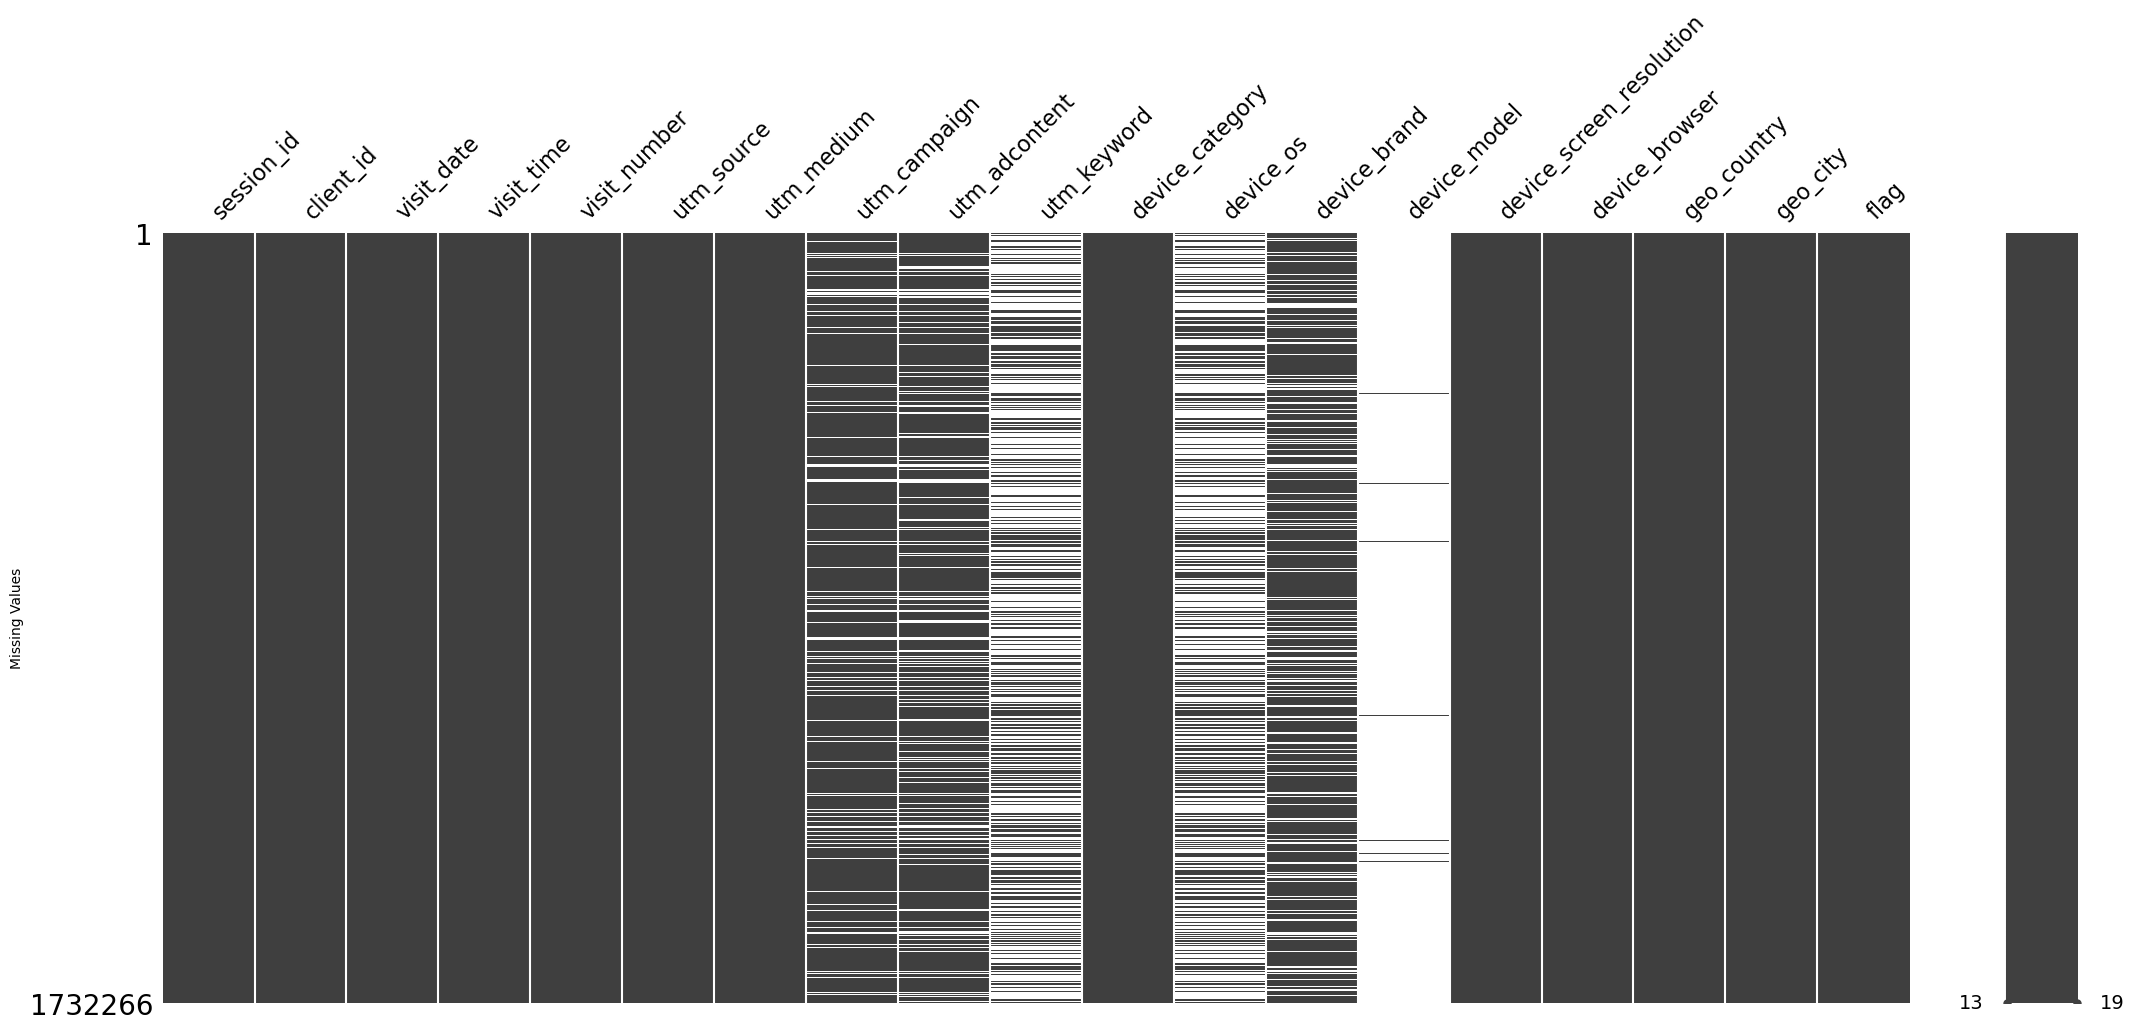

In [25]:
# Создание матрицы пропущенных значений
msno.matrix(merged_df)
plt.ylabel('Missing Values')

# Вычисление процентного значения пропущенных значений
missing_percentage = merged_df.isnull().mean() * 100

# Отображение процентного значения пропущенных значений на графике
ax = plt.gca()
for p in ax.patches:
    width = p.get_width()
    height = p.get_height()
    x, y = p.get_xy()
    ax.annotate(f'{height:.1f}%', (x + width / 2, y + height), ha='center', va='bottom')

plt.show()

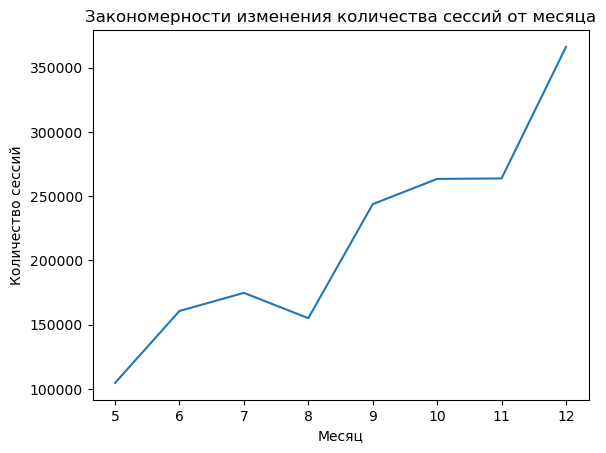

In [26]:
sessions_by_month = dnew.groupby('month')['session_id'].count()

# Построение графика
plt.plot(sessions_by_month.index, sessions_by_month.values)
plt.xlabel('Месяц')
plt.ylabel('Количество сессий')
plt.title('Закономерности изменения количества сессий от месяца')
plt.show()

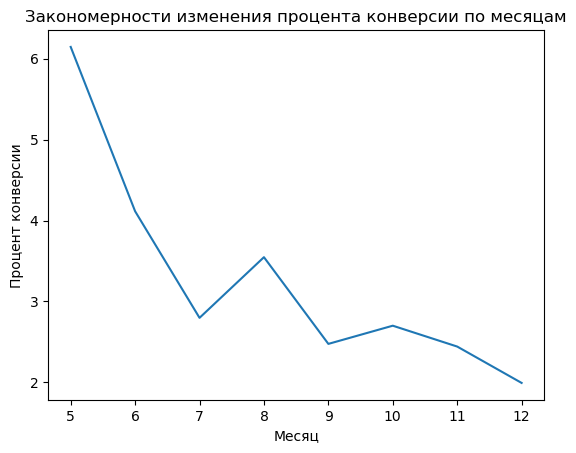

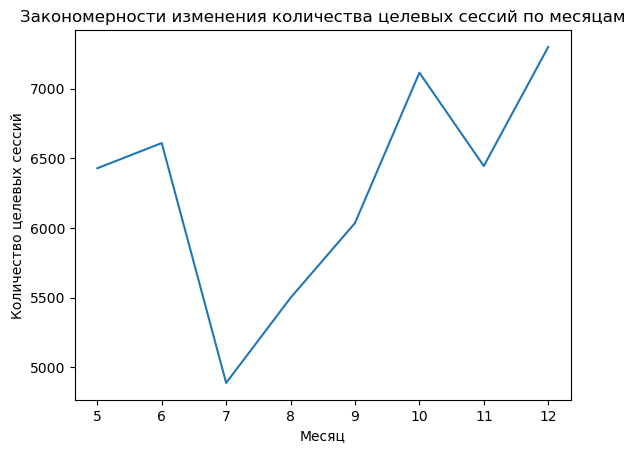

In [27]:
target_sessions_by_month = dnew[dnew['flag'] == 1].groupby('month')['session_id'].count()
# Вычисление процента конверсии
conversion_rate = (target_sessions_by_month / sessions_by_month) * 100
# Построение графика процента конверсии
plt.plot(conversion_rate.index, conversion_rate.values)
plt.xlabel('Месяц')
plt.ylabel('Процент конверсии')
plt.title('Закономерности изменения процента конверсии по месяцам')
plt.show()

# Построение графика количества целевых сессий по месяцам
plt.plot(target_sessions_by_month.index, target_sessions_by_month.values)
plt.xlabel('Месяц')
plt.ylabel('Количество целевых сессий')
plt.title('Закономерности изменения количества целевых сессий по месяцам')
plt.show()

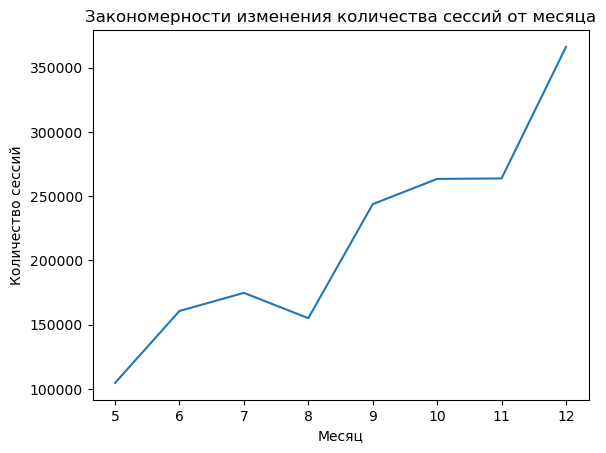

In [28]:
sessions_by_month = dnew.groupby('month')['session_id'].count()

# Построение графика
plt.plot(sessions_by_month.index, sessions_by_month.values)
plt.xlabel('Месяц')
plt.ylabel('Количество сессий')
plt.title('Закономерности изменения количества сессий от месяца')
plt.show()

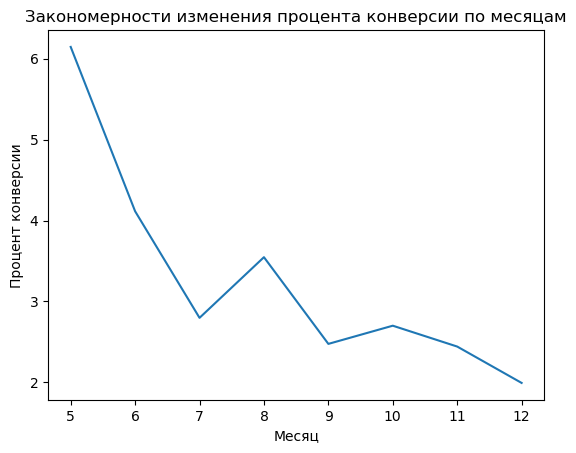

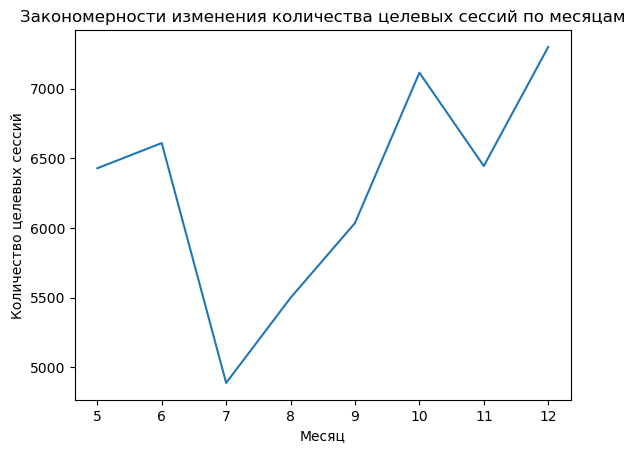

In [29]:
target_sessions_by_month = dnew[dnew['flag'] == 1].groupby('month')['session_id'].count()
# Вычисление процента конверсии
conversion_rate = (target_sessions_by_month / sessions_by_month) * 100
# Построение графика процента конверсии
plt.plot(conversion_rate.index, conversion_rate.values)
plt.xlabel('Месяц')
plt.ylabel('Процент конверсии')
plt.title('Закономерности изменения процента конверсии по месяцам')
plt.show()

# Построение графика количества целевых сессий по месяцам
plt.plot(target_sessions_by_month.index, target_sessions_by_month.values)
plt.xlabel('Месяц')
plt.ylabel('Количество целевых сессий')
plt.title('Закономерности изменения количества целевых сессий по месяцам')
plt.show()

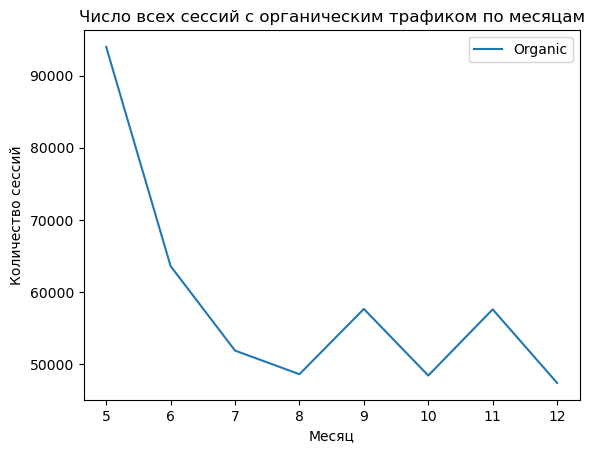

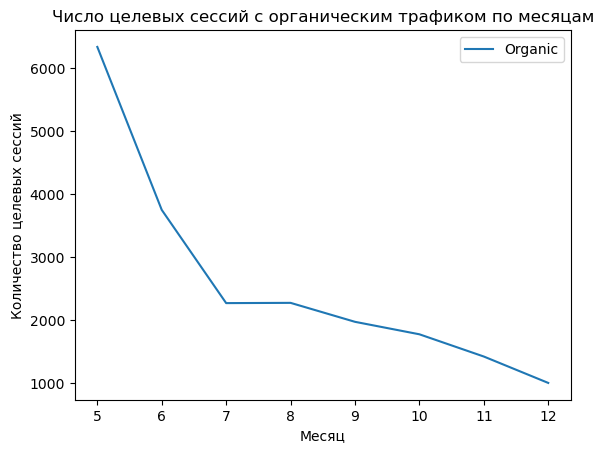

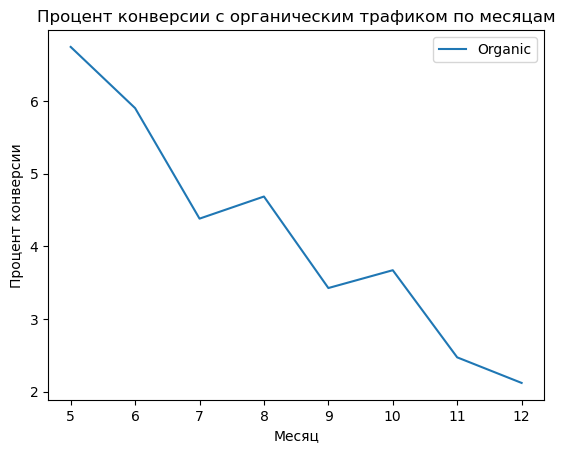

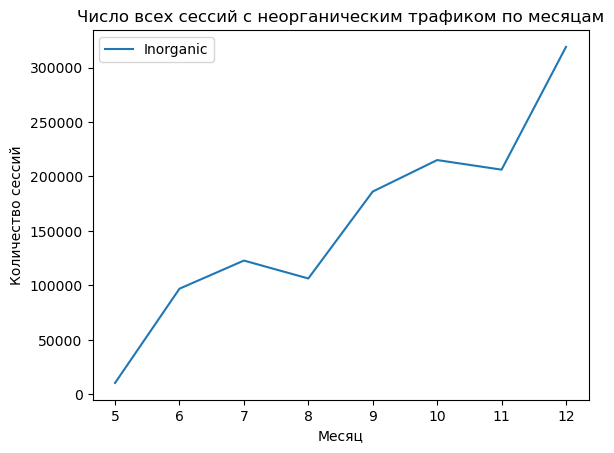

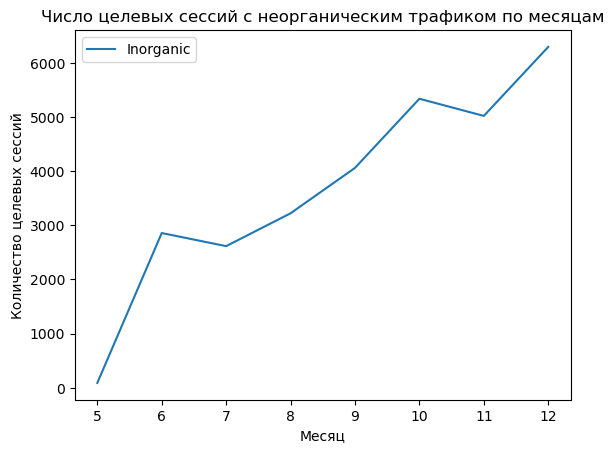

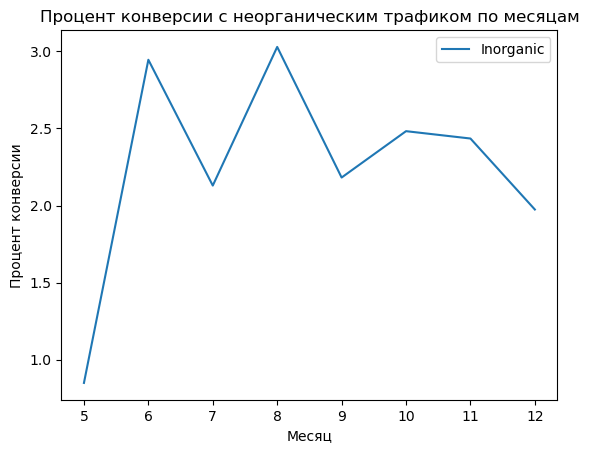

In [30]:
sessions_by_month_traffic = dnew.groupby(['month', 'traffic_type'])['session_id'].count().unstack()
target_sessions_by_month_traffic = dnew[dnew['flag'] == 1].groupby(['month', 'traffic_type'])['session_id'].count().unstack()

# Вычисление процента конверсии
conversion_rate_traffic = (target_sessions_by_month_traffic / sessions_by_month_traffic) * 100

# Построение графиков

# График числа всех сессий с органическим трафиком по месяцам
plt.plot(sessions_by_month_traffic.index, sessions_by_month_traffic['organic'], label='Organic')
plt.xlabel('Месяц')
plt.ylabel('Количество сессий')
plt.title('Число всех сессий с органическим трафиком по месяцам')
plt.legend()
plt.show()

# График числа целевых сессий с органическим трафиком по месяцам
plt.plot(target_sessions_by_month_traffic.index, target_sessions_by_month_traffic['organic'], label='Organic')
plt.xlabel('Месяц')
plt.ylabel('Количество целевых сессий')
plt.title('Число целевых сессий с органическим трафиком по месяцам')
plt.legend()
plt.show()

# График процента конверсии с органическим трафиком по месяцам
plt.plot(conversion_rate_traffic.index, conversion_rate_traffic['organic'], label='Organic')
plt.xlabel('Месяц')
plt.ylabel('Процент конверсии')
plt.title('Процент конверсии с органическим трафиком по месяцам')
plt.legend()
plt.show()

# График числа всех сессий с неорганическим трафиком по месяцам
plt.plot(sessions_by_month_traffic.index, sessions_by_month_traffic['inorganic'], label='Inorganic')
plt.xlabel('Месяц')
plt.ylabel('Количество сессий')
plt.title('Число всех сессий с неорганическим трафиком по месяцам')
plt.legend()
plt.show()

# График числа целевых сессий с неорганическим трафиком по месяцам
plt.plot(target_sessions_by_month_traffic.index, target_sessions_by_month_traffic['inorganic'], label='Inorganic')
plt.xlabel('Месяц')
plt.ylabel('Количество целевых сессий')
plt.title('Число целевых сессий с неорганическим трафиком по месяцам')
plt.legend()
plt.show()

# График процента конверсии с неорганическим трафиком по месяцам
plt.plot(conversion_rate_traffic.index, conversion_rate_traffic['inorganic'], label='Inorganic')
plt.xlabel('Месяц')
plt.ylabel('Процент конверсии')
plt.title('Процент конверсии с неорганическим трафиком по месяцам')
plt.legend()
plt.show()

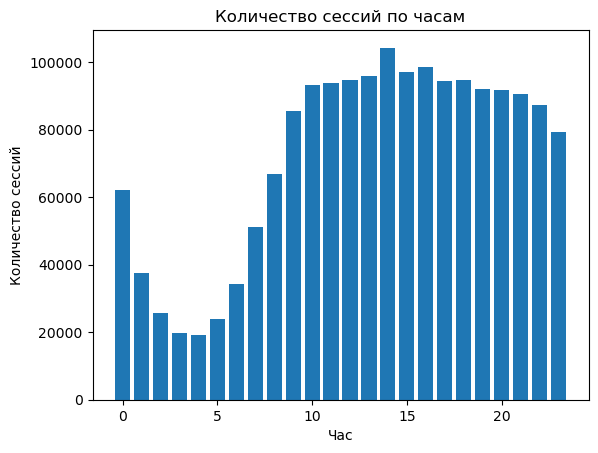

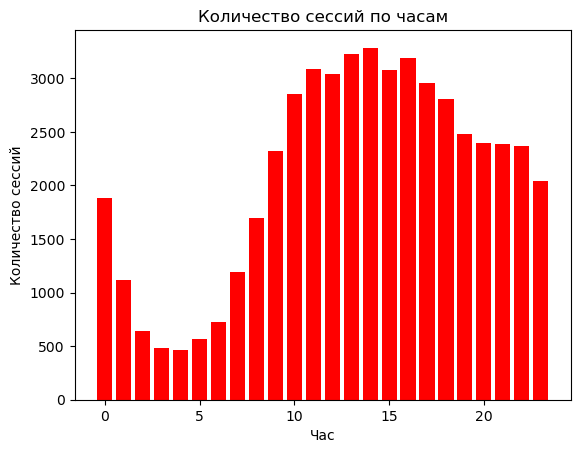

In [31]:
sessions_by_hour = dnew.groupby('hour')['session_id'].count()

# Группировка данных по часу и подсчет количества целевых сессий
target_sessions_by_hour = dnew[dnew['flag'] == 1].groupby('hour')['session_id'].count()

# Построение графика количества сессий по часам
#plt.plot(sessions_by_hour.index, sessions_by_hour.values)
x_values = sessions_by_hour.index
y_values = sessions_by_hour.values
plt.bar(x_values, y_values)
plt.xlabel('Час')
plt.ylabel('Количество сессий')
plt.title('Количество сессий по часам')
plt.show()

# Построение графика количества целевых сессий по часам
x_values = target_sessions_by_hour.index
y_values = target_sessions_by_hour.values
plt.bar(x_values, y_values, color='red')
plt.xlabel('Час')
plt.ylabel('Количество сессий')
plt.title('Количество сессий по часам')
plt.show()

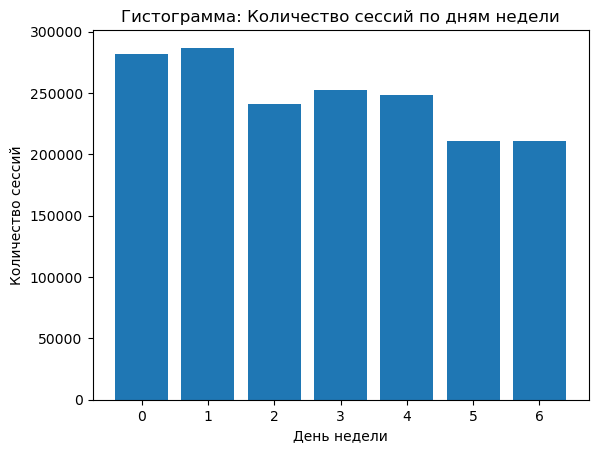

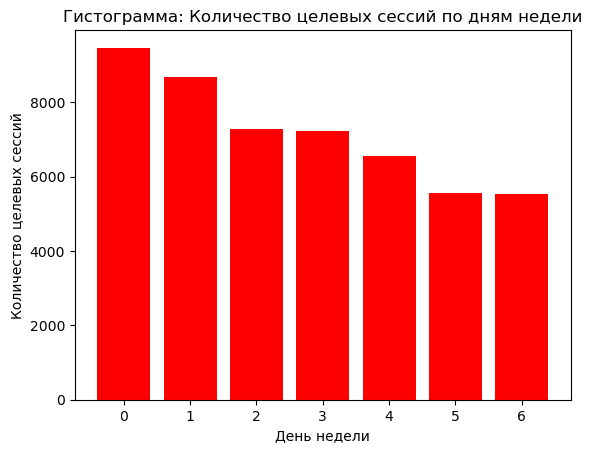

In [32]:
sessions_by_day = dnew.groupby('weekday')['session_id'].count()
target_sessions_by_day = dnew[dnew['flag'] == 1].groupby('weekday')['session_id'].count()

x_values = sessions_by_day.index
y_values = sessions_by_day.values
plt.bar(x_values, y_values)
plt.xlabel('День недели')
plt.ylabel('Количество сессий')
plt.title('Гистограмма: Количество сессий по дням недели')
plt.show()

x_values = target_sessions_by_day.index
y_values = target_sessions_by_day.values
plt.bar(x_values, y_values, color='red')
plt.xlabel('День недели')
plt.ylabel('Количество целевых сессий')
plt.title('Гистограмма: Количество целевых сессий по дням недели')
plt.show()



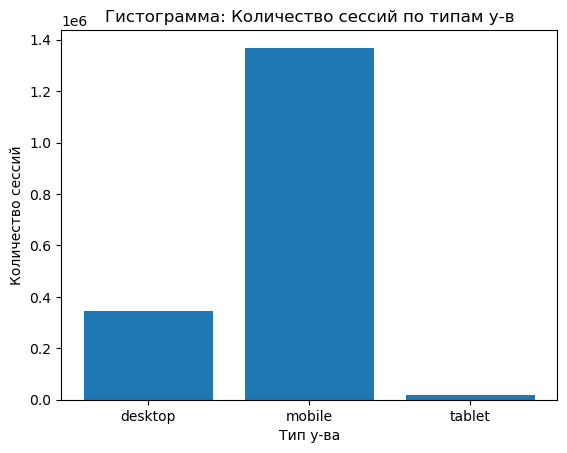

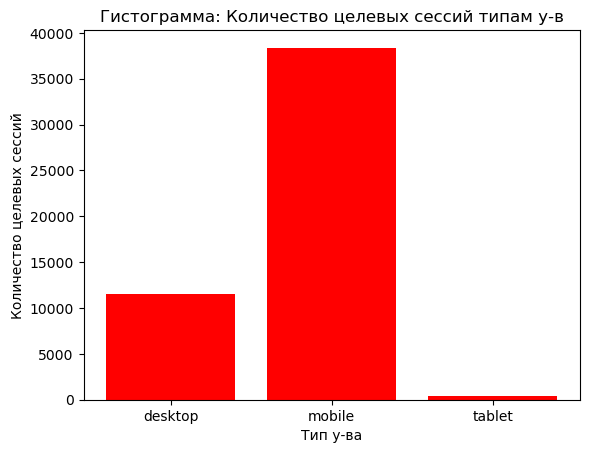

In [33]:
sessions_by_device = dnew.groupby('device_category')['session_id'].count()
target_sessions_by_device = dnew[dnew['flag'] == 1].groupby('device_category')['session_id'].count()

x_values = sessions_by_device.index
y_values = sessions_by_device.values
plt.bar(x_values, y_values)
plt.xlabel('Тип у-ва')
plt.ylabel('Количество сессий')
plt.title('Гистограмма: Количество сессий по типам у-в')
plt.show()

x_values = target_sessions_by_device.index
y_values = target_sessions_by_device.values
plt.bar(x_values, y_values, color='red')
plt.xlabel('Тип у-ва')
plt.ylabel('Количество целевых сессий')
plt.title('Гистограмма: Количество целевых сессий типам у-в')
plt.show()


# Modelling

In [34]:
X_train, X_test, y_train, y_test = train_test_split(dfn_drop.drop(['flag'], axis=1), dfn_drop['flag'], test_size=0.2, random_state=42)

In [35]:
print(X_train.shape)  
print(X_train.columns) 

(1385812, 26)
Index(['client_id', 'visit_number', 'utm_source', 'utm_medium', 'utm_campaign',
       'utm_adcontent', 'utm_keyword', 'device_category', 'device_os',
       'device_brand', 'device_model', 'device_screen_resolution',
       'geo_country', 'geo_city', 'day', 'weekday', 'month', 'hour',
       'device_browser_first', 'height', 'width', 'resolution_sum',
       'resolution_category', 'traffic_type', 'visit_date_timestamp',
       'visit_datetime_timestamp'],
      dtype='object')


In [36]:
if 'height' in categorical_features:
    categorical_features.remove('height')
if 'visit_date_timestamp' in categorical_features:
    categorical_features.remove('visit_date_timestamp')

In [37]:
print(categorical_features_indices)
print(X_train.columns[categorical_features_indices])

[2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 19, 23, 24]
Index(['utm_source', 'utm_medium', 'utm_campaign', 'utm_adcontent',
       'utm_keyword', 'device_category', 'device_os', 'device_brand',
       'device_model', 'device_screen_resolution', 'geo_country', 'geo_city',
       'height', 'traffic_type', 'visit_date_timestamp'],
      dtype='object')


In [38]:
categorical_features_indices = [X_train.columns.get_loc(c) for c in categorical_features if c in X_train.columns]
print("Категориальные признаки в X_train:", X_train.columns[categorical_features_indices])

Категориальные признаки в X_train: Index(['utm_source', 'utm_medium', 'utm_campaign', 'utm_adcontent',
       'utm_keyword', 'device_category', 'device_os', 'device_brand',
       'device_model', 'device_screen_resolution', 'geo_country', 'geo_city',
       'device_browser_first', 'resolution_category', 'traffic_type'],
      dtype='object')


In [39]:
print(categorical_features_indices)
print(X_train.columns[categorical_features_indices])
for col in categorical_features_indices:
    X_train.iloc[:, col] = X_train.iloc[:, col].astype(str)

[2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 18, 22, 23]
Index(['utm_source', 'utm_medium', 'utm_campaign', 'utm_adcontent',
       'utm_keyword', 'device_category', 'device_os', 'device_brand',
       'device_model', 'device_screen_resolution', 'geo_country', 'geo_city',
       'device_browser_first', 'resolution_category', 'traffic_type'],
      dtype='object')


In [40]:
valid_indices = [i for i in categorical_features_indices if i < X_train.shape[1]]
print("Валидные индексы категориальных признаков:", valid_indices)
print("Названия соответствующих столбцов:", X_train.columns[valid_indices])

Валидные индексы категориальных признаков: [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 18, 22, 23]
Названия соответствующих столбцов: Index(['utm_source', 'utm_medium', 'utm_campaign', 'utm_adcontent',
       'utm_keyword', 'device_category', 'device_os', 'device_brand',
       'device_model', 'device_screen_resolution', 'geo_country', 'geo_city',
       'device_browser_first', 'resolution_category', 'traffic_type'],
      dtype='object')


In [41]:
missing_percentage_nn = X_train.isnull().mean() * 100
print(missing_percentage_nn)

client_id                   0.0
visit_number                0.0
utm_source                  0.0
utm_medium                  0.0
utm_campaign                0.0
utm_adcontent               0.0
utm_keyword                 0.0
device_category             0.0
device_os                   0.0
device_brand                0.0
device_model                0.0
device_screen_resolution    0.0
geo_country                 0.0
geo_city                    0.0
day                         0.0
weekday                     0.0
month                       0.0
hour                        0.0
device_browser_first        0.0
height                      0.0
width                       0.0
resolution_sum              0.0
resolution_category         0.0
traffic_type                0.0
visit_date_timestamp        0.0
visit_datetime_timestamp    0.0
dtype: float64


## CatBoost Classifier

In [42]:
class_weights = [1, 15]  
model = CatBoostClassifier(
    iterations=1000,
    depth=6,
    learning_rate=0.1,
    loss_function='Logloss',
    random_state=42,
    verbose=100,
    cat_features=categorical_features_indices,
    class_weights=class_weights
)

model.fit(X_train, y_train)

0:	learn: 0.6720251	total: 1.69s	remaining: 28m 10s
100:	learn: 0.5587250	total: 2m 45s	remaining: 24m 30s
200:	learn: 0.5510961	total: 5m 26s	remaining: 21m 36s
300:	learn: 0.5463516	total: 8m 2s	remaining: 18m 40s
400:	learn: 0.5425447	total: 10m 40s	remaining: 15m 57s
500:	learn: 0.5394359	total: 13m 20s	remaining: 13m 17s
600:	learn: 0.5365576	total: 15m 58s	remaining: 10m 36s
700:	learn: 0.5337735	total: 18m 37s	remaining: 7m 56s
800:	learn: 0.5312221	total: 21m 18s	remaining: 5m 17s
900:	learn: 0.5286688	total: 23m 53s	remaining: 2m 37s
999:	learn: 0.5262644	total: 26m 28s	remaining: 0us


In [43]:
# Делаем предсказания на тестовых данных
y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)[:, 1]
# Оцениваем производительность модели
accuracy = accuracy_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_proba)
conf_matrix = confusion_matrix(y_test, y_pred)

print("Accuracy:", accuracy)
print("ROC-AUC:", roc_auc)
print("Confusion Matrix:\n", conf_matrix)



Accuracy: 0.9143666980320619
ROC-AUC: 0.711473765271505
Confusion Matrix:
 [[314397  21932]
 [  7736   2389]]


## Cross Validation

In [44]:
cv_scores = cross_val_score(model, X_train, y_train, cv=5, scoring='accuracy')  
# Выведем среднее значение точности и стандартное отклонение
print("Средняя точность:", cv_scores.mean())
print("Стандартное отклонение:", cv_scores.std())

0:	learn: 0.6734234	total: 1.22s	remaining: 20m 16s
100:	learn: 0.5584612	total: 2m 20s	remaining: 20m 50s
200:	learn: 0.5507592	total: 4m 33s	remaining: 18m 6s
300:	learn: 0.5452795	total: 6m 51s	remaining: 15m 54s
400:	learn: 0.5410438	total: 9m 12s	remaining: 13m 44s
500:	learn: 0.5370518	total: 11m 31s	remaining: 11m 28s
600:	learn: 0.5334858	total: 13m 42s	remaining: 9m 6s
700:	learn: 0.5302630	total: 15m 58s	remaining: 6m 48s
800:	learn: 0.5272447	total: 18m 13s	remaining: 4m 31s
900:	learn: 0.5240507	total: 20m 27s	remaining: 2m 14s
999:	learn: 0.5210201	total: 22m 40s	remaining: 0us
0:	learn: 0.6733489	total: 1.31s	remaining: 21m 46s
100:	learn: 0.5587946	total: 2m 15s	remaining: 20m 3s
200:	learn: 0.5508612	total: 4m 31s	remaining: 17m 59s
300:	learn: 0.5455646	total: 6m 53s	remaining: 16m
400:	learn: 0.5414190	total: 9m 12s	remaining: 13m 45s
500:	learn: 0.5376579	total: 11m 33s	remaining: 11m 30s
600:	learn: 0.5340119	total: 13m 50s	remaining: 9m 11s
700:	learn: 0.5306612	to

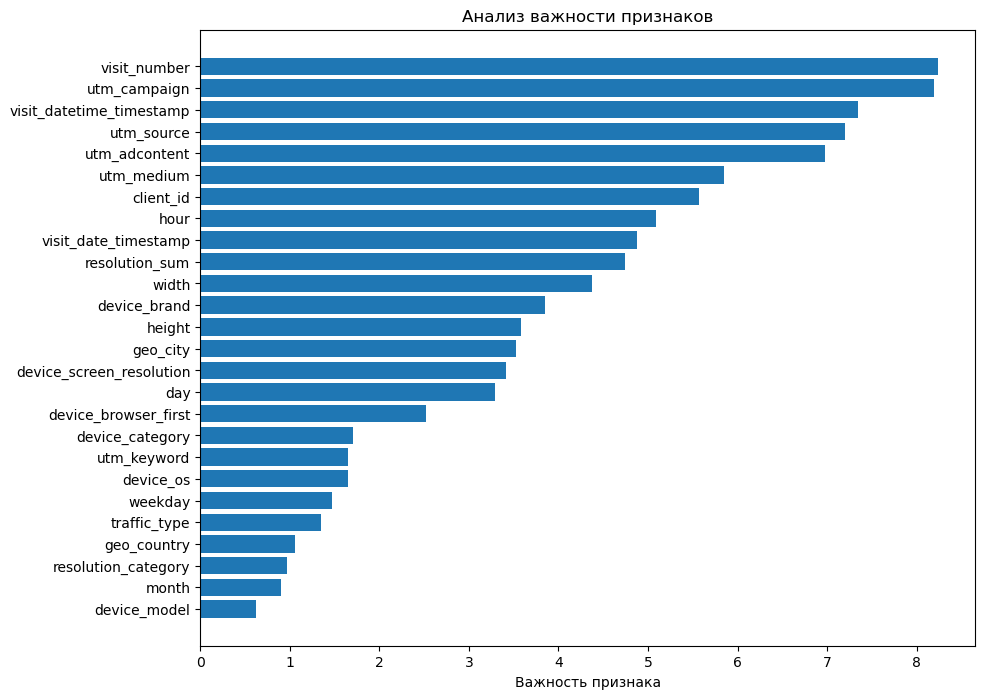

In [45]:
feature_importance = model.feature_importances_

# Сортировка признаков по их важности
sorted_idx = feature_importance.argsort()

# Визуализация важности признаков
plt.figure(figsize=(10, 8))
plt.barh(range(len(sorted_idx)), feature_importance[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), [X_test.columns[i] for i in sorted_idx])
plt.xlabel('Важность признака')
plt.title('Анализ важности признаков')
plt.show()

In [46]:
dfn_drop.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1732266 entries, 0 to 1732265
Data columns (total 27 columns):
 #   Column                    Dtype  
---  ------                    -----  
 0   client_id                 object 
 1   visit_number              float64
 2   utm_source                object 
 3   utm_medium                object 
 4   utm_campaign              object 
 5   utm_adcontent             object 
 6   utm_keyword               object 
 7   device_category           object 
 8   device_os                 object 
 9   device_brand              object 
 10  device_model              object 
 11  device_screen_resolution  object 
 12  geo_country               object 
 13  geo_city                  object 
 14  flag                      int64  
 15  day                       float64
 16  weekday                   float64
 17  month                     float64
 18  hour                      float64
 19  device_browser_first      object 
 20  height                  

In [47]:
finset =  dfn_drop.copy()
target_rows = finset[finset['flag'] == 1]
# Выбор случайной строки
random_row = target_rows.sample(n=1)
print(random_row['flag'])
# Удаление колонки 'flag', если она не используется в качестве признака для предсказания
input_data = random_row.drop(columns=['flag'])


1511007    1
Name: flag, dtype: int64


## Results

In [48]:
# Применение модели для предсказания
predicted_class = model.predict(input_data)

# Сделать предсказание вероятностей для классов
predicted_proba = model.predict_proba(input_data)[:, 1]  # для бинарной классификации, выбираем вероятность для класса 1

# Вывод предсказанного класса и вероятности
print("Predicted Class:", predicted_class)
print("Predicted Probability for class 1:", predicted_proba)

Predicted Class: [0]
Predicted Probability for class 1: [0.08971965]
